<h1 align="center">Classification</h1>

***

## MNIST
* A set of 70,000 small images of handwritten digits.
* Each image is labelled with digit it represents.
* It is often called "Hello World" of Machine Learning
* Scikit-Learn provides helper functions to download popular datasets.

In [1]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

try:    # see issue -> https://github.com/ageron/handson-ml/issues/7
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

mnist

Could not download MNIST data from mldata.org, trying alternative...
Success!


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

Datasets loaded by Sklearn generally have a similar dictionary structure including:
* A `DESCR` key describing dataset
* A `data` key containing an array with one row per instance and one columne per feature
* A`target` key containing an array with the labels

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images each of size 28x28 pixels, pixel desnsity varying from 0(white) to 255(black).

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

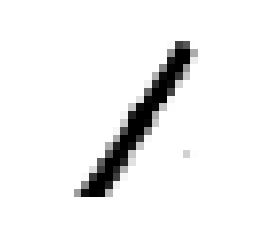

In [4]:
some_digit = X[10000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

Plotting 10 images from each category

In [5]:
def plot_10_image_per_category(imgs, categories):
    plt.figure(figsize=(7, 7))
    unique_classes = np.unique(categories)
    ctr = 1
    for i, cls in enumerate(unique_classes):
        cls_imgs = imgs[categories==cls]
        indices = np.random.randint(0, cls_imgs.shape[0], size=(10,))
        for index in indices:
            plt.subplot(10, 10, ctr)
            plt.imshow(cls_imgs[index].reshape(28, 28), cmap='binary', interpolation='nearest')
            plt.axis('off')
            ctr += 1
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

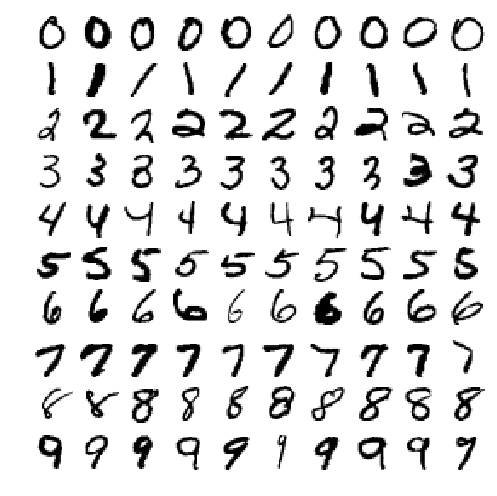

In [6]:
plot_10_image_per_category(X, y)

**Splitting in training and test set.**

This dataset is already have a split point at 60,000 mark. First 60,000 images are training set and last 10,000 are test set.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Shuffling train set to ensure that learning algorithms that are sensitive to order of the data are not affected by the order in this dataset.**

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier
* Simplifying the problem to - identify if digit is 5 or not
* The "5-detector" will be a *binary classifier*.

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

* A good place to start with is *Stochastic Gradient Descent (SGD)* classifier using scikit-learn's `SGDClassifier` class.
* This classifier has the advantage of being capable of handling very large datasets efficiently.
* It is suitable for online lerning as it trains on independent instances.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

***
> The `SGDClassifier` relies on randomness during training (hence the name 'stochastic'). If you want reproducible results, you should set the `random_state` parameter.
***

In [11]:
sgd_clf.predict([some_digit])

array([False])

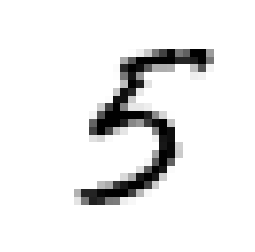

In [12]:
true_5_digit = X_train[y_train_5][1]
plt.imshow(true_5_digit.reshape(28, 28), cmap='binary', interpolation='nearest')
plt.axis('off')
plt.show()

In [13]:
sgd_clf.predict([true_5_digit])

array([ True])

## Performance Measures
* Large part of this chapter is dedicated to this topic as it is trickier to evaluate classifiers than regressors.

### Measuring Accuracy Using Cross Validation
* If you want more control over Cross Validation `than cross_val_score()` of sklearn you will need to implement it on your own. See [this](https://github.com/piyush2896/HandsOnML-Notes/tree/master/PART1-TheFundamentalsOfML/Ch03-Classification/cross_val.py) script for a sample implementation.
* Here we will use `cross_val_score()` to evaluate `SGDClassifier`.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96035, 0.9595 , 0.9422 ])

Before we get excited with accuracy, let's look at a very dumb classifier that just classifies every single image in "not-5" class:

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90995, 0.9107 , 0.9083 ])

On all cross-validations it got an accuracy of about 90%. This is because there are only 10% of images which represents 5. So it is correct the rest 90% of time!!

This demonstrates why accuracy is generally not a preferred performance measure for classifier, especially when we are dealing with *skewed datasets*.

### Confusion Matrix
* A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*.
* General idea: Count the number of times instances of class A are classified as instances of class B.
* Example, to know the number of times the classifier confused images of 5s with 3s, we will look in the 5th row and 2nd column of the matrix.
* Let's compute the confusion matrix

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53377,  1202],
       [ 1557,  3864]])

* Each row represents a actual class
* Each column represents a predicted class
* First row of matrix considers non-5 images (the negative class). Here 1987 are wrongly classified as instance of the positive class or are *false positives (FP)*. The rest are *True Negatives (TN)*.
* Second row of matrix considers the images of 5s (the positive class). Here 764 are wrongly classified as instance of the negative class or are *false negatives (FN)*. The rest are *True Positives (TP)*.

|![Confusion Matrix](./images/confusion_matrix.png)|
|:------------------------------------------------:|
| Confusion Matrix|

### Precision and Recall
* Confusion matrix gives a lot of information, but sometimes we may prefer a more consice metric.
  
* Accuracy of positive predictions - **precision** of the classifier.
$$precision = \frac{TP}{TP + FP}$$
* But we can get 100% precision just by making 1 predictions and ensuring that it is correct (precision = 1/1 = 100%).
* So it is typically used with other metric, called **recall**, also called **senistivy** or **true positive rate (TPR)**. This is ratio of positive instances that are correctly classified by the classifier.
$$recall = \frac{TP}{TP+FN}$$

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7627319384129491

In [19]:
recall_score(y_train_5, y_train_pred)

0.7127836192584394

* It is often convenient to combine precision and recall into a single metric called $F_1$ *score*.
* It is the *harmonice mean* of precision and recall. Harmonic mean givesmuch more weight to low values

$$F_{1} = \frac{2}{\dfrac{1}{precision} + \dfrac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \dfrac{FN + FP}{2}}$$

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7369123676933347

* The $F_1$ score favors classifiers that have similar precision and recall. This is not always what we want!
* In some cases we want more precision and in some case we want more recall
* Example, we migth want our classifier to throw away many good videos (low recall) but make sure to have safe videos (high precision) for kids.

* Increasing precision reduces recall and vice-versa. This is called *precision/recall tradeoff*.

### Precision/Recall Tradeoff
* Let's look at how `SGDClassifier` makes its classification decisions.
* For each instance it computes a score based on a decision function and if the score is > a threshold it assigns it positive class.

|![Precision vs Recall](./images/fig0303.jpg)|
|:------------------------------------------:|
|Precision/Recall Tradeoff|

* Scikit-learn doesn't let you set threshold directly, but it gives you access to the decision scores that it uses to make predictions.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-226606.32566331])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = sgd_clf.decision_function([true_5_digit])
y_scores

array([83067.1284013])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The `SGDClassifier` keeps threshold of 0, Let's increase it tp 200,000

In [25]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Raising the threshold increases precision and decreases the recall, and vice-versa.**

How to decide the threshold?
* Use `cross_val_predict()` to predict using `decision_function()` and then plot precision recall curve using `precision_recall_curve()` method.

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [28]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([-0.02, 1.02])

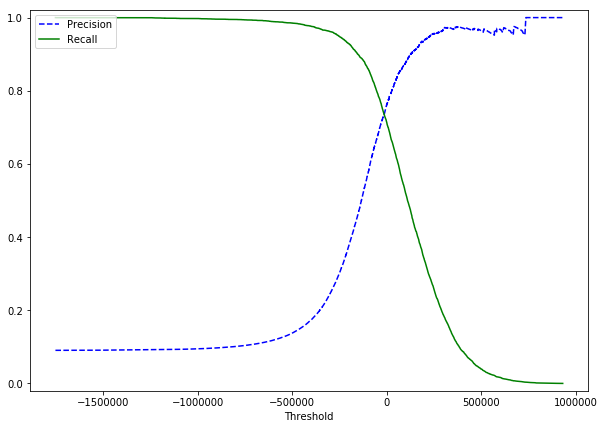

In [29]:
plt.figure(figsize=(10, 7))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

***
> Precision curve is bumpier than Recall curve as the precision may go down when we raise the threshold (although in general it won't). Recall always decreases as threshold increases, this means that its curve will be smoother.
***

* Now we can select the threshold value that gives us the best precision/recall tradeoff.
* Another way to select the threshold is to plot precision directly against recall.

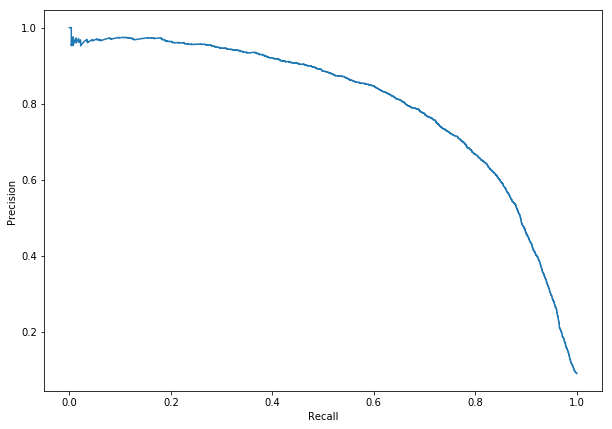

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

* Precision starts to fall around 70% recall. We might want to set the tradeoff just before the drop.
* If we aim for 90% precision, we look at the first plot and see that we need a threshold of about 90,000.

In [52]:
y_train_pred_90 = (y_scores > 90000)

In [53]:
precision_score(y_train_5, y_train_pred_90)

0.8712166172106824

In [54]:
recall_score(y_train_5, y_train_pred_90)

0.541597491237779

A high precision classifier is not useful if you have very low recall!!

***
> If someone says "let's reach 99% precision", you should ask, "at what recall?"
***

### The ROC curve
* The *receiver operating curve (ROC)* is another common tool used with binary classifiers.
* It plots the *true positive rates* (another name for recall) against *false positive rate*.
* FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - *specificity* (True Negative Rate)
* True Negative Rate is the ratio of Negative instances which are classified correctly as negatives.

* So ROC plots sensitivity (recall) against 1-specificity

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

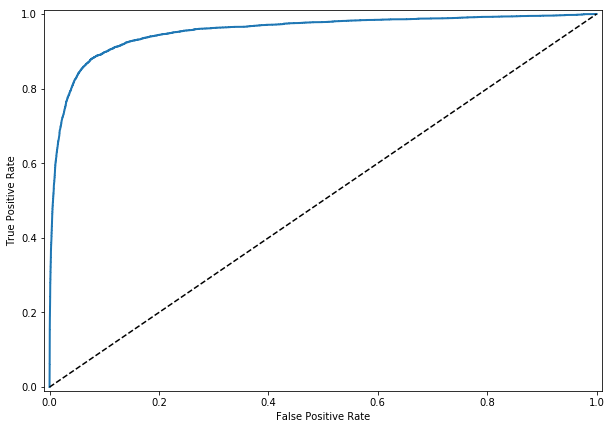

In [36]:
plt.figure(figsize=(10, 7))
plot_roc_curve(fpr, tpr)
plt.show()

* Once again there is a tradeoff: the higher the recall, the more false positives (FPR) the classifier produces.
* Dotted line represents the ROC of a purely random classifier. A good classifier stays away from this line as possible.
* One way to compare classifiers is to measure the *area under the curve* (*AUC*). A perfect classifier will have a *ROC AUC* equal to 1, whereas a purely random classifier will have *ROC AUC* 0.5

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.954749250842657

***
> Since ROC is so similar to precision/recall (PR) curve. As a rule of thumb, we should prefer PR curve whenever the positive class is rare or when you care more about false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But it is mostly because there are few positives (5s) compared to the negatives (non 5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top right corner).
***

Let's compare it to the `RandomForestClassifier`

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

But we need scores not probabilities. A simple solution is to use the positive class's score:

In [39]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

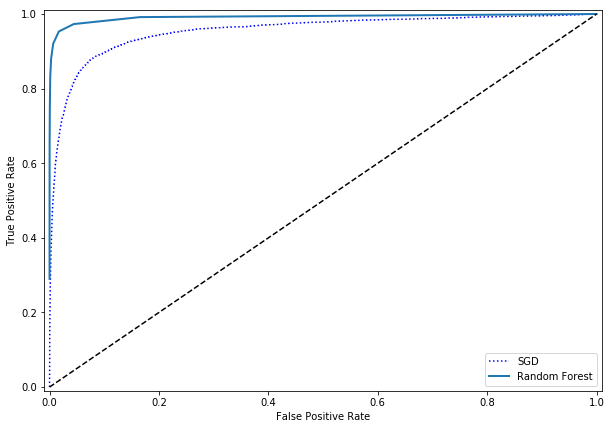

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9917982445960833

*ROC* of Random Forest looks better than *ROC* of SGD

In [42]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9851040525739321

In [43]:
recall_score(y_train_5, y_train_pred_forest)

0.8295517432208079

## Multiclass Classification
* *Multiclass Classifiers* (or *Multinomial Classifier*) can distinguish between more than two classes.
* Some algorithms (such as *Random Forest Classifers* or *Naive Bayes*) are capable of handling multiple classes directly. Others (such as *Support Vector Machines Classifiers* or *Linear Classifiers*) are strictly binary classifiers.
* There are many strategies that we can use to perform multiclass classification using multiple binary classifiers.

**One-vs-All (OvA):**
One way to use binary classifier to classify images into 10 digits is to use 10 classifiers, one for each digit (a 0-detector, a 1-detector and so on). Then use the highest decision score for an image out of decision scores from all the detectors. This is called *one-vs-all (OvA)*

**One-vs-One (OvO):**
Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s from 2s, another for 1s from 2s and so on. This is called *one-vs-one (OvO)*. If there are *N* classes we need *N x (N - 1) / 2* classifiers. One advantage of OvO is that each classifier is trained on the part if the training set for the two classes that it must distinguish.

*SVMs scale poosly with amount of data so OvO is preferred for them.*

**Scikit-learn detects when we are using binary classifer for multiclass classification and automatically runs OvA (for SVMs it runs OvO).**

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit, true_5_digit])

array([1., 5.])

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-485348.58360828,   61298.14324704,  -91653.02869614,
        -148438.62416755, -369533.90001421, -226606.32566331,
        -278928.82889155, -293607.93273665, -185229.96066044,
        -222274.54415081]])

In [47]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [48]:
sgd_clf.classes_[np.argmax(some_digit_scores[0])]

1.0

***
> When a classifier is trained, it stores the list of target classes in its `classes_attribute`, orderd by value. In this case, the index of each class in the `classes_` array conveniently matches the class itself, but in general we won't be so lucky.
***

If we want to use OvO rather than OvA, we can use `OneVsOneClassifier` or `OneVsRestClassifier` classes.

In [49]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False),
          n_jobs=1)

In [50]:
ovo_clf.predict([some_digit, true_5_digit])

array([1., 5.])

In [51]:
len(ovo_clf.estimators_)

45

Training Random Forest Classifier is also easy

In [55]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit, true_5_digit])

array([1., 5.])

In [56]:
forest_clf.predict_proba([some_digit])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [57]:
forest_clf.predict_proba([true_5_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

Let's evaluate `SGDClassifier`'s accuracy using `cross_val_score()` function:

In [58]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.83343331, 0.87739387, 0.85482822])

Let's scale the inputs

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [60]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90716857, 0.90939547, 0.90893634])

## Error Analysis
* If this was a real ML project we would have gone through the ML checklist like chapter 2.
* We assume here that we have found a good model and want to improve on it. One way to do it is to analyze the types of errors it makes.
* Let's visualize confusion matrix

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5742,    2,   19,    7,   10,   47,   41,   12,   40,    3],
       [   2, 6447,   52,   26,    6,   50,    9,   13,  125,   12],
       [  62,   34, 5348,   82,   84,   24,   97,   61,  154,   12],
       [  44,   41,  142, 5319,    2,  256,   32,   58,  141,   96],
       [  22,   24,   33,    9, 5374,    8,   55,   34,   77,  206],
       [  72,   37,   31,  210,   71, 4587,  111,   24,  178,  100],
       [  36,   23,   55,    2,   51,   87, 5617,    3,   43,    1],
       [  25,   16,   73,   29,   53,   11,    6, 5806,   13,  233],
       [  50,  147,   72,  163,   16,  171,   54,   26, 5006,  146],
       [  45,   28,   22,   83,  151,   38,    2,  232,   84, 5264]])

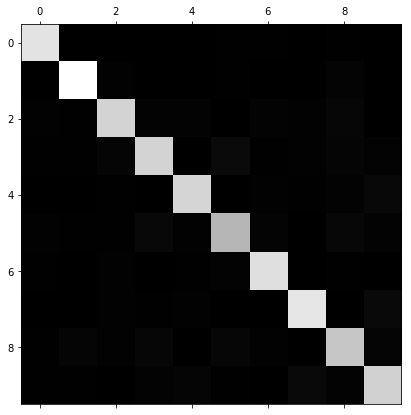

In [66]:
plt.figure(figsize=(7, 7))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=False)
plt.show()

We want to compare the error rate not the absolute numbers. Let's normalize

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

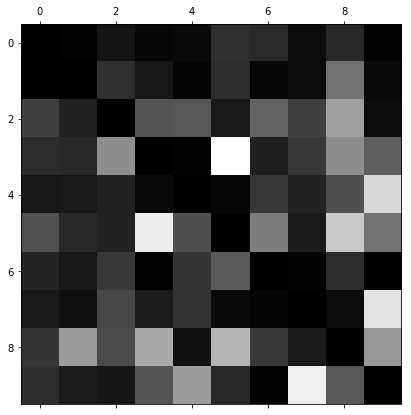

In [69]:
np.fill_diagonal(norm_conf_mx, 0) # fill the diagonal with zeros to keep only the errors
plt.figure(figsize=(7, 7))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=False)
plt.show()

* Columns represent predicted classes and Rows represent actual classes.
* The columns for 9s and 8s are quite bright, representing that many images get misclassified as 8s or 9s.
* Similarly rows of 8s and 9s are quite bright, representing that they are confused as other digits.
* Note that the errors are not perfectly symmetrical, for example, there are more 3s misclassified as 5s than the reverse.
* Looking at the plot it seems that your efforts should be spent on improving classifications of 8s and 9s, as well as fixing the specific 3/5 confusion.
* Example solution - gather more data or engineer new images

* Analyzing individual errors can also give a good insight. But it is more difficult and time consuming.

In [72]:
def plot_digits(instances, images_per_row=10, **options): # code from -> https://github.com/ageron/handson-ml
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [71]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

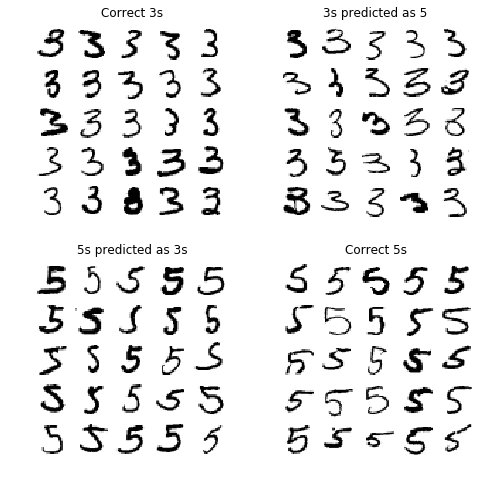

In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5); plt.title('Correct 3s')
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5); plt.title('3s predicted as 5')
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5); plt.title('5s predicted as 3s')
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5); plt.title('Correct 5s')
plt.show()

* One difference between 3s and 5s is the position to the slight line joining the top and bottom part of the digit.
* This means the model is sensitive to the image rotations or slight other effects. We can create engineered images to resolves this.

## Multilabel Classification
How will we do multilabel classification? Let's see an example

In [75]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # Number greater than equal to 7 or not
y_train_odd = (y_train % 2 == 1) # Number odd or not
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
knn_clf.predict([some_digit, true_5_digit])

array([[False,  True],
       [False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric depends on the type of the project. Example one approach is to measure the *F1 score* for each label and then average over them.

In [77]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9689488891753258

## Multioutput Classification
* *Multioutput-multiclass Classification* is simply a generalization of multilabeled classification where each label can be multiclass.
* Let's build a system that removes noise from images.

***
> The line between classification and regression is sometimes blurry. Arguably predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; we caould even have a system outputs muliplt labels per instance, including both class labels and value labels.
***

Let's create train and test sets by adding noise to the MNIST images.

In [83]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a look at an image from the test set.

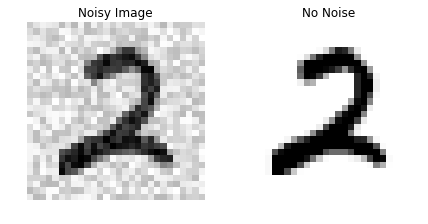

In [86]:
some_index = np.random.randint(len(X_test))

plt.figure(figsize=(7, 7))
plt.subplot(121)
plt.title('Noisy Image')
plt.imshow(X_test_mod[some_index].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.subplot(122)
plt.title('No Noise')
plt.imshow(y_test_mod[some_index].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

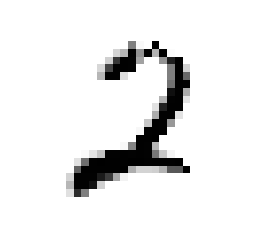

In [92]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plt.imshow(clean_digit[0].reshape((28, 28)), cmap='binary')
plt.axis('off')
plt.show()

# Exercises
**Coming Soon.**